# Rusty Bargain Used Car  - Value Prediction

## Introduction

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Data preparation

In [1]:
# Import Libraries

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

import time

In [2]:
# Load Dataset

df = pd.read_csv('/datasets/car_data.csv')
df.sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,21/03/2016 09:50,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,21/03/2016 00:00,0,2694,21/03/2016 10:42
354365,14/03/2016 17:48,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,14/03/2016 00:00,0,39576,06/04/2016 00:46
354366,05/03/2016 19:56,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,05/03/2016 00:00,0,26135,11/03/2016 18:17
354367,19/03/2016 18:57,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,19/03/2016 00:00,0,87439,07/04/2016 07:15


In [3]:
# Check for missing values

print(df.isna().sum())

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


In [4]:
# Percent of values missing

percent_missing = df.isnull().sum() * 100 / len(df)
print(round(percent_missing,2))

DateCrawled           0.00
Price                 0.00
VehicleType          10.58
RegistrationYear      0.00
Gearbox               5.60
Power                 0.00
Model                 5.56
Mileage               0.00
RegistrationMonth     0.00
FuelType              9.28
Brand                 0.00
NotRepaired          20.08
DateCreated           0.00
NumberOfPictures      0.00
PostalCode            0.00
LastSeen              0.00
dtype: float64


There are significant missing values, with some columns even having as high as 10 or 20% of their values missing. So the missing value data is not dropped, but rather filled in with the mean or mode depending on the type of data.

Models with missing values will be filled with unknown as they cannot be filled with mode.

In [5]:
# Deal with missing values

# 'Model', 'VehicleType', 'Gearbox','FuelType', and 'NotRepaired' columns are filled with 'Unknown'
df['Model'] = df['Model'].fillna('other')
df['VehicleType'] = df['VehicleType'].fillna('unknown')
df['Gearbox'] = df['Gearbox'].fillna('unknown')
df['FuelType'] = df['FuelType'].fillna('unknown')
df['NotRepaired'] = df['NotRepaired'].fillna('unknown')


In [6]:
# Ensure all missing values are dealt with

print(df.isna().sum())

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Mileage              0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64


In [7]:
# Check for duplicates

print(df.duplicated().sum())

263


In [8]:
# Remove duplicates

df = df.drop_duplicates()
print(df.duplicated().sum())

0


In [9]:
# Check Data Types

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354106 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354106 non-null  object
 1   Price              354106 non-null  int64 
 2   VehicleType        354106 non-null  object
 3   RegistrationYear   354106 non-null  int64 
 4   Gearbox            354106 non-null  object
 5   Power              354106 non-null  int64 
 6   Model              354106 non-null  object
 7   Mileage            354106 non-null  int64 
 8   RegistrationMonth  354106 non-null  int64 
 9   FuelType           354106 non-null  object
 10  Brand              354106 non-null  object
 11  NotRepaired        354106 non-null  object
 12  DateCreated        354106 non-null  object
 13  NumberOfPictures   354106 non-null  int64 
 14  PostalCode         354106 non-null  int64 
 15  LastSeen           354106 non-null  object
dtypes: int64(7), object(

In [10]:
# Fix data types

# DateCrawled, DateCreated, and LastSeen should be of datetime data type
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format = '%d/%m/%Y %H:%M')
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format = '%d/%m/%Y %H:%M')
df['LastSeen'] = pd.to_datetime(df['LastSeen'], format = '%d/%m/%Y %H:%M')

# # PostalCode should be of object datatype
# df['PostalCode'] = df['PostalCode'].astype('object')

print(df.info())

/tmp/ipykernel_32/2589485666.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format = '%d/%m/%Y %H:%M')
/tmp/ipykernel_32/2589485666.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DateCreated'] = pd.to_datetime(df['DateCreated'], format = '%d/%m/%Y %H:%M')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 354106 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354106 non-null  datetime64[ns]
 1   Price              354106 non-null  int64         
 2   VehicleType        354106 non-null  object        
 3   RegistrationYear   354106 non-null  int64         
 4   Gearbox            354106 non-null  object        
 5   Power              354106 non-null  int64         
 6   Model              354106 non-null  object        
 7   Mileage            354106 non-null  int64         
 8   RegistrationMonth  354106 non-null  int64         
 9   FuelType           354106 non-null  object        
 10  Brand              354106 non-null  object        
 11  NotRepaired        354106 non-null  object        
 12  DateCreated        354106 non-null  datetime64[ns]
 13  NumberOfPictures   354106 non-null  int64   

/tmp/ipykernel_32/2589485666.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LastSeen'] = pd.to_datetime(df['LastSeen'], format = '%d/%m/%Y %H:%M')


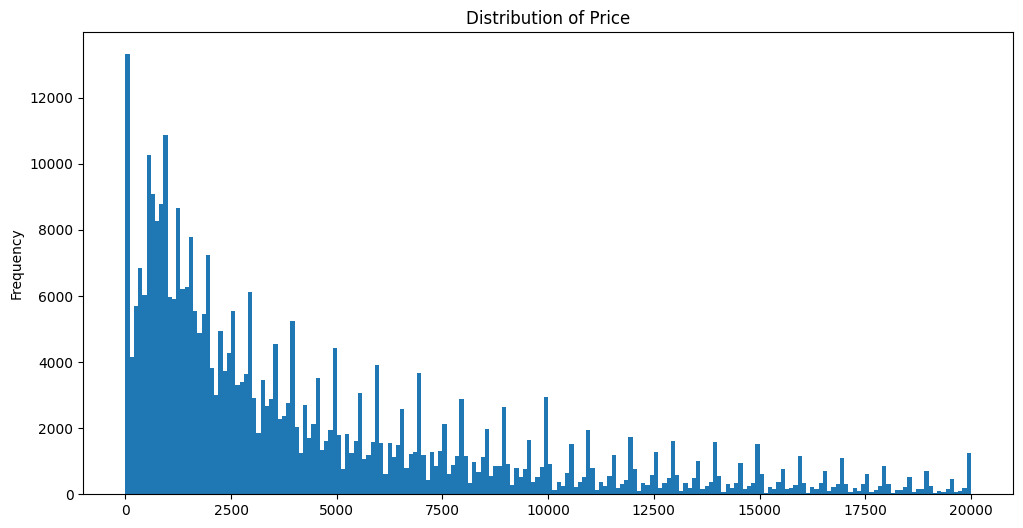

In [11]:
# Check for outliers in Price column

df['Price'].plot( kind='hist',
                         title = 'Distribution of Price',
                         ylabel = 'Frequency',
                         xlabel = 'Price',
                         bins = 200,
                         figsize = [12,6]
                               )
plt.show()


There are a lot of entries with the price as very close to 0, which does not make sense in car sales dataset, so those entries should be checked and dropped.

In [12]:
# Analyze car prices close to 0:

print(df['Price'].value_counts().sort_values())

print('\nStats on the Price')
print(df['Price'].describe())

print('\n5th percentile')
print(df['Price'].quantile(0.05))
print('\n10th percentile')
print(df['Price'].quantile(0.1))

8188         1
2101         1
1587         1
19770        1
3378         1
         ...  
1200      4589
1000      4647
1500      5391
500       5667
0        10770
Name: Price, Length: 3731, dtype: int64

Stats on the Price
count    354106.000000
mean       4416.443785
std        4514.340636
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

5th percentile
200.0

10th percentile
499.0


As it can be seen here, 10 percent of the car prices are below 600, and 5% are below 400, and there are a lot of 0 and 1 as the car price. To make the car prices more reasonable, all prices below 300 are dropped

In [13]:
# Dropping all price entries under 300 as those don't make sense 

df = df[df['Price'] > 300]

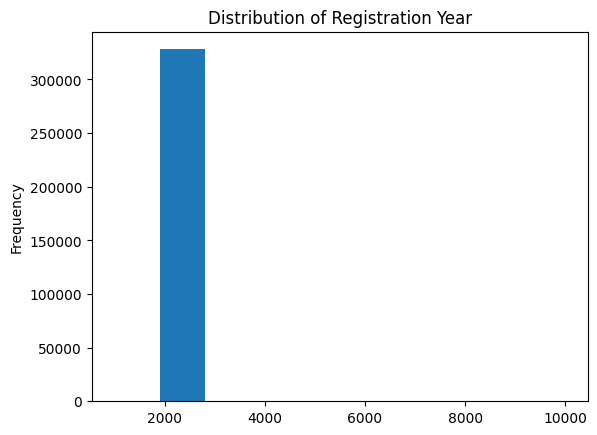

In [15]:
# Check for outliers in Registration Year column

df['RegistrationYear'].plot( kind='hist',
                         title = 'Distribution of Registration Year',
                         ylabel = 'Frequency',
                         xlabel = 'Registration Year',
                               )
plt.show()

No outliers noticed in the Registration Year column

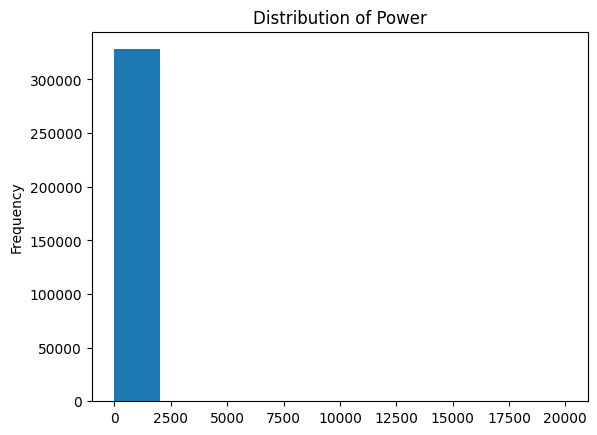

In [16]:
# Check for outliers in Power column

df['Power'].plot( kind='hist',
                         title = 'Distribution of Power',
                         ylabel = 'Frequency',
                         xlabel = 'Power'
                               )
plt.show()

There seems to be cars with 0 as the Power, so it needs to be analyzed

In [17]:
print('\nStats on the Power')
print(df['Power'].describe())

print('\n5th percentile')
print(df['Power'].quantile(0.05))
print('\n10th percentile')
print(df['Power'].quantile(0.1))


Stats on the Power
count    328217.000000
mean        113.408745
std         187.301567
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

5th percentile
0.0

10th percentile
41.0


Based on the above stats and the fact that the lowest possible power a car can have is 8, all entries with the Power under 8 are dropped

In [18]:
# Dropping all power entries of 0 as those don't make sense 

df = df[df['Power'] >= 8]

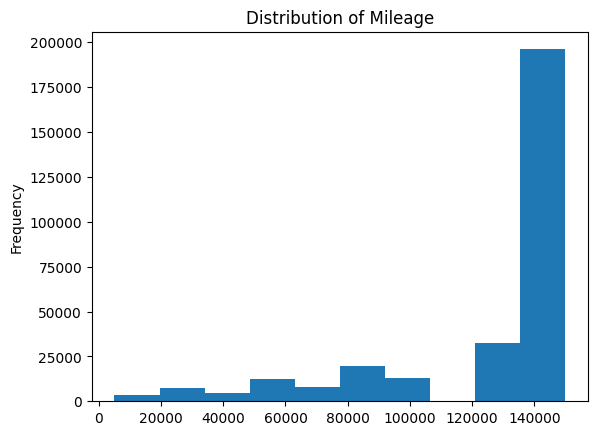

In [19]:
# Check for outliers in Mileage column

df['Mileage'].plot( kind='hist',
                         title = 'Distribution of Mileage',
                         ylabel = 'Frequency',
                         xlabel = 'Mileage'
                               )
plt.show()

No outliers are noticed in the Mileage column.

In [20]:
# Check cardinality of different categorical features

print(df.select_dtypes(include='object').nunique())


VehicleType      9
Gearbox          3
Model          249
FuelType         8
Brand           40
NotRepaired      3
dtype: int64


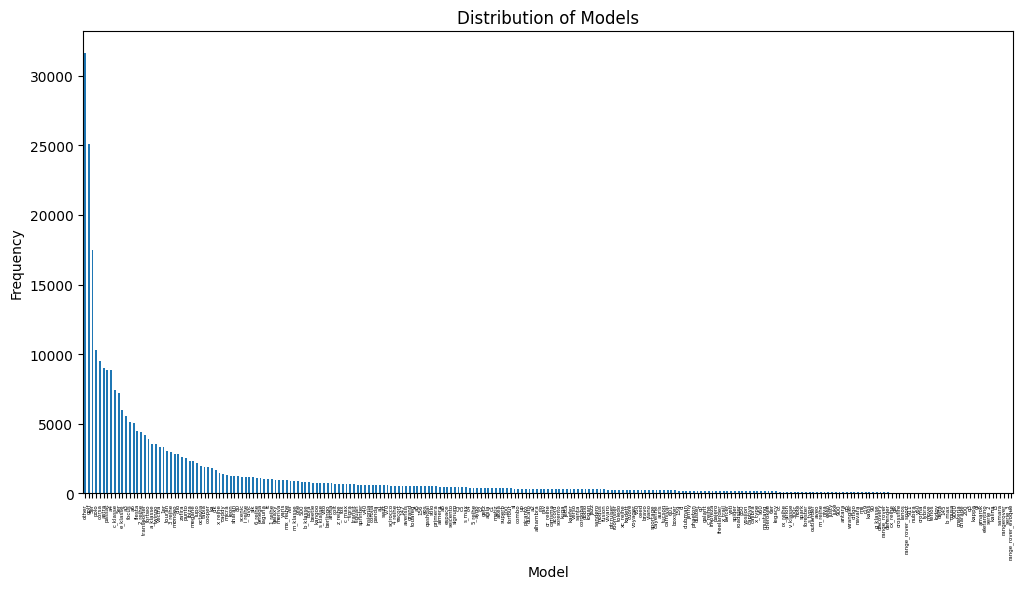

In [21]:
# Check the distribution of the models values

df['Model'].value_counts().plot( kind='bar',
                         title = 'Distribution of Models',
                         ylabel = 'Frequency',
                         xlabel = 'Model',
                         figsize = [12,6]
                               )
plt.xticks(fontsize=4)
plt.show()


The above figure shows that there are a lot of models that don't occur very often in the dataset. The top 50 models are plotted to see the distribution more closely.

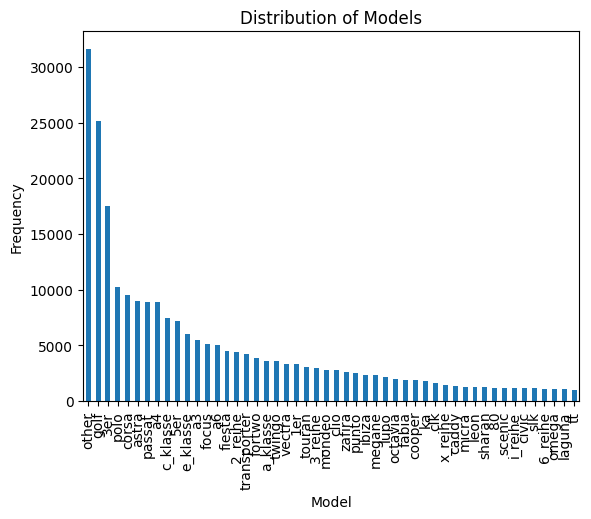

In [22]:
# Distribution of the top 50 models
df['Model'].value_counts()[:50].plot( kind='bar',
                     title = 'Distribution of Models',
                     ylabel = 'Frequency',
                     xlabel = 'Model',
                    )
plt.show()

The 'other' and 'golf' models has a lot more values compared to other models. It seems to be an outlier as there are over 40000 entries for 'other' and 30,000 for 'golf' compared to the under 10,000 entried for most. Golf is an actual model and seems to be big in the used car sales dataset, other is just for all the unknown ones.

Based on the above graph we can easily take the top 40 models here and lump the rest together to make the data simpler to use.

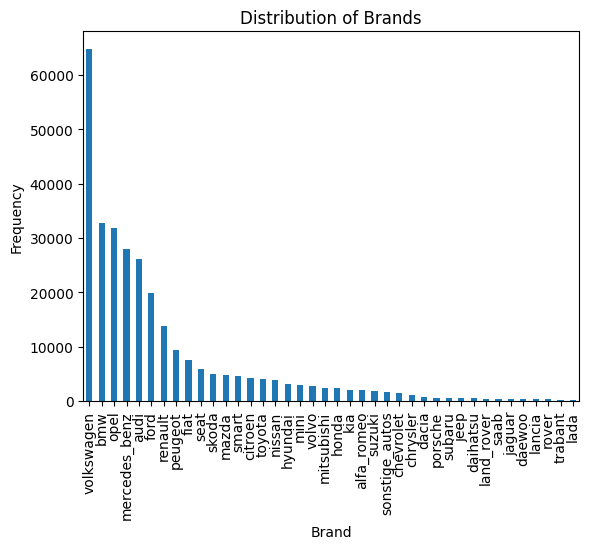

In [23]:
# Check the distribution of the brands values

df['Brand'].value_counts().plot( kind='bar',
                 title = 'Distribution of Brands',
                 ylabel = 'Frequency',
                 xlabel = 'Brand',
                )
plt.show()

Volkswagen brand is an outlier here as it has close to 75,000 entries compared to the rest of the brands where even the next most popular brand is open at 40,000 entries at almost half that. This makes sense as we have a lot of entries for the Golf model which is a Volkwagen brand. Volkswagen Golf seems to be a popular brand and model for used car sales, and will have a significant impact on the models.

Based on the above graph we can easily take the top 30 brands here and lump the rest together to make the data simpler to use.

In [24]:
# One-Hot Encoding 

# Only keep the top 40 models to simplify data to use for regression models
threshold = 40  
top_categories = df['Model'].value_counts().nlargest(threshold).index
df['Model'] = df['Model'].apply(
    lambda x: x if x in top_categories else 'other')

# Only keep the top 30 brands to simplify data to use for regression models
threshold = 30  
top_categories = df['Brand'].value_counts().nlargest(threshold).index
df['Brand'] = df['Brand'].apply(
    lambda x: x if x in top_categories else 'other')


df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe.sample(10)

,DateCrawled,Price,RegistrationYear,Power,Mileage,RegistrationMonth,DateCreated,NumberOfPictures,PostalCode,LastSeen,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
1,2016-03-24 10:58:00,18300,2011,190,125000,5,2016-03-24,0,66954,2016-04-07 01:46:00,...,0,0,0,0,0,0,0,0,0,1
2,2016-03-14 12:52:00,9800,2004,163,125000,8,2016-03-14,0,90480,2016-04-05 12:47:00,...,0,0,0,0,0,0,0,0,1,0
3,2016-03-17 16:54:00,1500,2001,75,150000,6,2016-03-17,0,91074,2016-03-17 17:40:00,...,0,0,0,0,0,0,1,0,0,0
4,2016-03-31 17:25:00,3600,2008,69,90000,7,2016-03-31,0,60437,2016-04-06 10:17:00,...,1,0,0,0,0,0,0,0,0,0
5,2016-04-04 17:36:00,650,1995,102,150000,10,2016-04-04,0,33775,2016-04-06 19:17:00,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354361,2016-03-09 13:37:00,5250,2016,150,150000,12,2016-03-09,0,51371,2016-03-13 01:44:00,...,0,0,0,0,0,0,0,0,0,0
354362,2016-03-19 19:53:00,3200,2004,225,150000,5,2016-03-19,0,96465,2016-03-19 20:44:00,...,0,0,0,0,0,0,0,0,0,1
354366,2016-03-05 19:56:00,1199,2000,101,125000,3,2016-03-05,0,26135,2016-03-11 18:17:00,...,0,1,0,0,0,0,0,0,0,0
354367,2016-03-19 18:57:00,9200,1996,102,150000,3,2016-03-19,0,87439,2016-04-07 07:15:00,...,0,0,0,0,0,0,1,0,0,0


In [25]:
# Split data into training and test set

df_ohe_features = df_ohe.drop(['Price', 'DateCrawled', 'DateCreated', 'LastSeen'], axis=1)

features_train, features_test, target_train, target_test = train_test_split(
    df_ohe_features, df_ohe['Price'], test_size=0.25, random_state=12345)

# Scale the features


scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)


One-Hot Encoding was used for the categorical variables, but certain features like Model and Brand were a high cardinality feature with there being 250 unique models and 40 unique brands. The extent of these two features was limited by using the top 40 Models and top 30 brands only, while lumping the remaining in an 'other' category. This was done to save on processing power as without it there were too many features and the computational bandwith of the system was not enough to sustain that.

## Model training

In [26]:
# Linear Regression - sanity check

model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

start_time_lr = time.time()
prediction_lr = model_lr.predict(features_test)
lr_prediction_time = time.time() - start_time_lr

rmse_lr = mean_squared_error(target_test, prediction_lr, squared=False)
print('RMSE for Linear Regression:', rmse_lr)
print(f'Linear Regression Prediction Time: {lr_prediction_time:.2f} seconds')


RMSE for Linear Regression: 3259.1529936166658
Linear Regression Prediction Time: 0.01 seconds


In [27]:
# Random Forest Regressor - Finetune Hyperparameters

param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
}

rf_model = RandomForestRegressor()

random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid_rf, 
                                   scoring='neg_mean_squared_error', n_iter=5, cv=3, verbose=1, random_state=42, n_jobs=-1)

start_time = time.time()
random_search_rf.fit(features_train, target_train)
search_time = time.time() - start_time

# Get the best parameters and model
best_params_rf = random_search_rf.best_params_
best_model_rf = random_search_rf.best_estimator_

print("Best Parameters:", best_params_rf)
# print("Best MSE Score:", best_score_rf)
print('Randomized Search Hyperparameter tuning time - Random Forest:', search_time)



Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': None}
Randomized Search Hyperparameter tuning time - Random Forest: 977.2143354415894


In [28]:
# Random Forest Regressor - Using the best model to predict

start_time_rf = time.time()
prediction_rf = best_model_rf.predict(features_test)
rf_prediction_time = time.time() - start_time_rf

rmse_rf = mean_squared_error(target_test, prediction_rf, squared=False)
print('RMSE for Random Forest Regressor:', rmse_rf)
print(f'Random Forest Regressor Prediction Time: {rf_prediction_time:.2f} seconds')


RMSE for Random Forest Regressor: 1566.4792749007822
Random Forest Regressor Prediction Time: 2.91 seconds


In [29]:
# Light GBM Regressor (LGBMRegressor) - Finetune Hyperparameters

# Define a smaller and more focused parameter grid
param_distributions = {
    'num_leaves': np.arange(20, 60, 10),
    'max_depth': np.arange(5, 15, 5),
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
}

# Initialize the model
lgb_model = lgb.LGBMRegressor()

# Perform random search with fewer iterations
random_search = RandomizedSearchCV(estimator=lgb_model, param_distributions=param_distributions, 
                                   scoring='neg_mean_squared_error', n_iter=10, cv=3, verbose=1, random_state=42, n_jobs=-1)

start_time = time.time()
random_search.fit(features_train, target_train)
search_time = time.time() - start_time

# Get the best parameters and model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Print the best parameters and search time
print("Best parameters found: ", best_params)
print(f"Randomized Search Hyperparameter tuning time - Light GBM: {search_time:.2f} seconds")



Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'subsample': 0.7, 'num_leaves': 50, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Randomized Search Hyperparameter tuning time - Light GBM: 181.56 seconds


In [30]:
# Light GBM Regressor (LGBMRegressor) - Use the best model to predict

start_time_lgb = time.time()
prediction_lgb = best_model.predict(features_test)
lgb_prediction_time = time.time() - start_time_lgb

# Calculate RMSE
rmse_lgb = mean_squared_error(target_test, prediction_lgb, squared=False)

print('RMSE for LightGBM:', rmse_lgb)
print(f'LightGBM Prediction Time: {lgb_prediction_time:.2f} seconds')

RMSE for LightGBM: 1606.5537394544754
LightGBM Prediction Time: 1.40 seconds


In [31]:
# Cat Boost Regressor
 
model_cb = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, random_seed=12345)   
model_cb.fit(features_train, target_train, verbose=10)

start_time_cb = time.time()
prediction_cb = model_cb.predict(features_test)
cb_prediction_time = time.time() - start_time_cb

rmse_cb = mean_squared_error(target_test, prediction_cb, squared=False)
print('RMSE for Cat Boost Regressor:', rmse_cb)
print(f'Cat Boost Regressor Prediction Time: {lgb_prediction_time:.2f} seconds')

# model = CatBoostClassifier(loss_function="Logloss", iterations=150, random_seed=12345)
# model.fit(features_train, target_train, cat_features=cat_features, verbose=10)


0:	learn: 4297.3102201	total: 75.6ms	remaining: 7.49s
10:	learn: 2735.2076341	total: 328ms	remaining: 2.65s
20:	learn: 2282.6983114	total: 575ms	remaining: 2.16s
30:	learn: 2097.7853988	total: 808ms	remaining: 1.8s
40:	learn: 2008.1646927	total: 1.04s	remaining: 1.49s
50:	learn: 1949.9958770	total: 1.27s	remaining: 1.22s
60:	learn: 1907.1071141	total: 1.5s	remaining: 959ms
70:	learn: 1875.6518533	total: 1.73s	remaining: 708ms
80:	learn: 1854.1904194	total: 1.97s	remaining: 461ms
90:	learn: 1835.3146124	total: 2.19s	remaining: 216ms
99:	learn: 1820.6656705	total: 2.39s	remaining: 0us
RMSE for Cat Boost Regressor: 1821.2396396530978
Cat Boost Regressor Prediction Time: 1.40 seconds


In [32]:
# XGBoost

model_xgb = xgb.XGBRegressor(n_estimators=10, learning_rate=0.1, max_depth=3)
model_xgb.fit(features_train, target_train)


start_time_xgb = time.time()
prediction_xgb = model_xgb.predict(features_test)
xgb_prediction_time = time.time() - start_time_xgb

rmse_xgb = mean_squared_error(target_test, prediction_xgb, squared=False)
print('RMSE for XGBoost:', rmse_xgb)
print(f'XGBoost Classifier Prediction Time: {xgb_prediction_time:.2f} seconds')


RMSE for XGBoost: 3459.7234535772395
XGBoost Classifier Prediction Time: 0.11 seconds


## Model analysis - Conclusion

We first ran a Linear Regression model as a sanity check to make sure all other models do better than that in terms of its accuracy (calculated through RMSE). Linear Regression model gave a RMSE of 3259 with a prediction time of only 0.01 seconds.

Compared to that, Random Forest Regression after some hypertuning of parameters gave a RMSE of 1566 with a prediction time of 2.91 seconds, but it took roughly 16 minutes (977 seconds) to find the best parameters using Randomized Search.

The different gradient boosting models used were LightGBM, Catboost, and XGBoost. After some hypertuning of parameters, LightGBM Regressor gave a RMSE of 1606 with a prediction time of 1.40 seconds, but it took 3 minutes (181 seconds) time to hypertune the parameters. Catboost Regressor gave a RMSE of 1821 with a prediction time of 1.40 seconds, whereas XGBoost gave a RMSE of 3459 with a prediction time of 0.11 seconds.

As we can see- Random Forest Regressor, Light GBM Regressor and Catboost Regressor gave the lowest RMSE. Light GBM gave the lowest RMSE at 1606 but that was with hypertuning which took a few minues, whereas Catboost gave a slightly higher RMSE at 1821 but no hypertuning was done so it was done within 1.40 seconds. Even though Random Forest Regressor gave the lowest RMSE at 1566, it took 16 minutes to find the best parameters for the model so that isn't the best choice.